In [74]:
#Application of knowledge learned through PyTorch.com Pytorch Turorials
#Dataset from Kaggle, shoe images
#Remove all .DS_store files in folders, ls-a

from __future__ import print_function, division

#Torch, Torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import time
import os
import shutil
import copy

##Image import settings
datafolder_name = "shoedata"
datafolder_name_use = datafolder_name + "use"
datafolder_name_use


'shoedatause'

In [75]:
# rename and group all images
reset_img_folder = True
if reset_img_folder:
    try:
        print("removing used folder")
        !rm -rf {datafolder_name_use}
        print("duplicating original folder")
        !cp -r {datafolder_name} {datafolder_name_use}
    except FileNotFoundError as e:
        !cp -r {datafolder_name} {datafolder_name_use}
        print("duplicating original folder")
    
    
folders = ["train", "val", "test"]
try:
    for folder in folders:
        
        ds_store_path = os.path.join(datafolder_name_use, folder, ".DS_Store")
        !rm {ds_store_path}

        i = 0
        #extract images from category folders
        for brand in ['adidas', 'converse', 'nike']:
            for imgpath in os.listdir(os.path.join(datafolder_name_use,folder,brand)):
                
                os.rename(
                        os.path.join(datafolder_name_use,folder,brand,imgpath),

                        os.path.join(datafolder_name_use,folder,brand +"_"+ str(i) + ".png")

                         )
                i+=1
            os.rmdir(os.path.join(datafolder_name_use,folder,brand))
except FileNotFoundError as e:
    print(e)

removing used folder
duplicating original folder


In [76]:
#Transfor

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(240),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(240),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(240),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [77]:
#Index ordering does not matter, for each new class of shoe:
                                        #add the name of the folder, and increasing index
    
    
class_names = {
    'adidas':0,
    'converse':1,
    'nike':2

    #ex.
    #'reebok':3, 
}
    
class_list = [key for key in class_names]

#Dataset class for an image folder containing images of format (label_idx.jpg)
#idx should be unique within a label
class ShoeDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_classes = class_list
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

  
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, os.listdir(self.img_dir)[idx])
        image = Image.open(img_path)
        label = torch.tensor(class_names[(img_path.split("_")[0].split("/")[-1])], dtype = torch.uint8)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

In [78]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def board_convert(inp, title=None):
    pass

In [79]:
#for testing on real world
def get_batch_size(folder, desired_imgs = 4):
    if folder == 'test':
        return desired_imgs
    else:
        return 8

#have train, val, test from camera pics
data_dir = datafolder_name_use
image_datasets = {x: ShoeDataset(os.path.join(data_dir, x)
                                 ,data_transforms[x]
                                )
                  for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=get_batch_size(x, desired_imgs=4),
                                             shuffle= x != 'test')
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}



In [80]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [81]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    
#                     print(outputs, " ", labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [82]:
model_ft = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_list))


In [83]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/shoeclass_1')

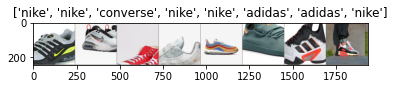

In [84]:
#optional - launch tensorboard: tensorboard --logdir=runs

# Get a batch of training data

inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_list[int(x)] for x in classes])

# write to tensorboard
writer.add_image('shoe_images', out)

#write the final model to tensorboard
writer.add_graph(model_ft, inputs.cpu())
writer.close()

In [85]:
#Project images/features into 3D space on tensorboard, I like TSNE
#higher quality or more photos may take the algorithm slightly longer, this is unmeasred
#so far, only green channel is being looked at
#(*TODO*) include all three channels

num_images_to_sample = 100
# select random images and their target indices
data = [image_datasets['train'][x] for x in range(0,num_images_to_sample)]

# get the class labels for each image
class_labels = [class_list[int(lab[1])] for lab in data[0:num_images_to_sample]]

images = torch.stack([img[0][1] for img in data[0:num_images_to_sample]])

print(images.shape)
# print(images.unsqueeze(-1).shape)
features = images.view(-1, 240 * 240)
print(features.shape)

writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

torch.Size([100, 240, 240])
torch.Size([100, 57600])


In [86]:
model_ft = model_ft.to(device)

#Loss function
criterion = nn.CrossEntropyLoss()

#Optimizer on model parameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#train the model for num_epochs
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.0000 Acc: 0.5865
val Loss: 0.0000 Acc: 0.7456

Epoch 1/24
----------
train Loss: 0.0000 Acc: 0.7328
val Loss: 0.0000 Acc: 0.8158

Epoch 2/24
----------



KeyboardInterrupt



In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_list[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model_ft, num_images=3)